# Similarity Modeling 1/2: Recognizing Pigs with Deep Learning

## Student
Gallus Huber (51905700)

## Timesheet
2022-10-16 09:00 - 12:30 SIM 1 & 2 <br />
2022-10-16 15:00 - 17:00 SIM 3 <br />
2022-10-18 10:00 - 13:00 SIM 4 & 5 <br />
2022-10-27 20:00 - 22:00 SIM 6 <br />
2022-10-28 10:00 - 14:00 SIM 7 & 8 & 9 <br />
2022-11-02 08:00 - 14:00 Writing abstracts <br />
2022-11-10 14:00 - 15:00 Meeting <br />
2022-11-24 16:00 - 17:30 Setup <br />
2022-11-26 09:00 - 12:00 Implementation data preparation <br />
2022-11-27 10:00 - 10:30 Meeting <br />
2022-11-27 10:30 - 15:00 Implementation model <br />
2022-12-01 16:00 - 20:00 Training of model <br />

## Required libraries and installs

In [2]:
!cat requirements-dl-video.txt
#!pip install -r requirements-dl-video.txt

pandas
numpy
opencv-python
matplotlib
scikit-learn
tensorflow
keras
visualkeras

## Imports

In [28]:
import os
import glob
import pathlib
import collections

import pandas as pd
import numpy as np

import cv2 as cv2
import matplotlib.pyplot as plt

import sklearn.model_selection as ms
import skimage.transform as trans

import keras.applications as appl
import keras.models as models
import keras.layers as layers
import keras.utils as utils
import keras.callbacks as callbacks

import visualkeras

## Constants

In [2]:
# path to ground truth and videos
DATA_PATH = "../data"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "sim12-ground-truth-muppets")
VIDEO_PATH = os.path.join(DATA_PATH, "video")

# path to save and load trained models
MODEL_PATH = "../models/video"

# Project structure

In [3]:
# create dirs for training
train_path = os.path.join(VIDEO_PATH, 'training_data')
train_path_0 = os.path.join(train_path, '0')
train_path_1 = os.path.join(train_path, '1')

# create dirs for validation
valid_path = os.path.join(VIDEO_PATH, 'validation_data')
valid_path_0 = os.path.join(valid_path, '0')
valid_path_1 = os.path.join(valid_path, '1')

# create dirs for testing
test_path = os.path.join(VIDEO_PATH, 'testing_data')
test_path_0 = os.path.join(test_path, '0')
test_path_1 = os.path.join(test_path, '1')

In [7]:
# create dirs for training
if not os.path.exists(train_path):
    os.makedirs(train_path)
if not os.path.exists(train_path_0):
    os.makedirs(train_path_0)
if not os.path.exists(train_path_1):
    os.makedirs(train_path_1)

# create dirs for validation
if not os.path.exists(valid_path):
    os.makedirs(valid_path)
if not os.path.exists(valid_path_0):
    os.makedirs(valid_path_0)
if not os.path.exists(valid_path_1):
    os.makedirs(valid_path_1)

# create dirs for testing
if not os.path.exists(test_path):
    os.makedirs(test_path)
if not os.path.exists(test_path_0):
    os.makedirs(test_path_0)
if not os.path.exists(test_path_1):
    os.makedirs(test_path_1)

# 1. Data Preparation

## 1.1 List all videos

In [4]:
videos = glob.glob(VIDEO_PATH + '/*.avi')

videos_tmp = []
for video in videos:
    videos_tmp.append(pathlib.Path(video).name)
videos = videos_tmp

videos

['Muppets-02-01-01.avi', 'Muppets-03-04-03.avi', 'Muppets-02-04-04.avi']

## 1.2 Load ground truth

### 1.2.1 Read ground truth from CSV

In [ ]:
ground_truth = dict()

# read in corresponding ground truth
for video in videos:
        file_name = glob.glob(GROUND_TRUTH_PATH + '/*' + os.path.splitext(video)[0] + '*.csv')
        csv = pd.read_csv(os.path.join(file_name[0]), sep=";")
        ground_truth[video] = csv

### 1.2.2 Plot the ground truth

In [ ]:
def plot_gt(gt, column):
    plot = plt.figure(figsize=(10, 4))

    # define subplot
    subplot = plot.add_subplot(111)
    subplot.set_title(f"Occurrences in Frames")

    # define x axis
    subplot.set_xlabel('Frames')

    # mark occurrences
    frame_indicator = np.zeros(len(gt['Frame_number']))
    frame_indicator[gt[gt[column] == 1].index] = 1

    subplot.plot(gt[column].index, frame_indicator)
    plt.show()

for video in videos:
    plot_gt(ground_truth[video], "Pigs")

## 1.3 Load video data

### 1.3.1 Data structure to store splits

In [ ]:
train_data = dict()
valid_data = dict()
test_data = dict()

### 1.3.2 Create splits
The ground truth is split into training set, validation set and testing set.

In [ ]:
for video in videos:
    train_data[video], test_data[video] = ms.train_test_split(ground_truth[video], test_size=0.2, shuffle=True, random_state=42)
    train_data[video], valid_data[video] = ms.train_test_split(train_data[video], test_size=0.25, random_state=42)

### 1.3.3 Get frames of video
The frames are written to the corresponding directory based on the splits and ground truth.

In [ ]:
def retrieve_frames(video_file):
    # open a videoCap for this video
    video_cap = cv2.VideoCapture(os.path.join(VIDEO_PATH, video_file))

    # used to identify frame in ground truth
    frame_nr = 0

    # read all frames of video
    while True:
        # get one frame
        success_read, frame_read = video_cap.read()

        # no more frames available
        if not success_read:
            break

        # create filename
        filename = 'frame_%d.jpg' % frame_nr

        # write frames to dir
        if frame_nr in train_data[video_file].Frame_number:
            if (train_data[video_file][train_data[video_file].Frame_number == frame_nr].Pigs == 0).bool():
                cv2.imwrite(os.path.join(train_path_0, filename), frame_read)
            else:
                cv2.imwrite(os.path.join(train_path_1, filename), frame_read)

        elif frame_nr in valid_data[video_file].Frame_number:
            if (valid_data[video_file][valid_data[video_file].Frame_number == frame_nr].Pigs == 0).bool():
                cv2.imwrite(os.path.join(valid_path_0, filename), frame_read)
            else:
                cv2.imwrite(os.path.join(valid_path_1, filename), frame_read)

        elif frame_nr in test_data[video_file].Frame_number:
            if (test_data[video_file][test_data[video_file].Frame_number == frame_nr].Pigs == 0).bool():
                cv2.imwrite(os.path.join(test_path_0, filename), frame_read)
            else:
                cv2.imwrite(os.path.join(test_path_1, filename), frame_read)

        # go to next frame
        frame_nr += 1


for video in videos:
    retrieve_frames(video)
    print(f"Loaded frames of {video} successfully")

# 2 Model

## 2.1 Build model

### 2.1.1 Create the model

In [31]:
# create base model -> pretrained model
base_model = appl.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# base model as input
head_model = base_model.output

# additional hidden layer
head_model = layers.Dense(512, activation='sigmoid')(head_model)
head_model = layers.Flatten(name="flatten")(head_model)

# create output layer
head_model = layers.Dense(1, activation="softmax")(head_model)

model = models.Model(inputs=base_model.input, outputs=head_model)

# base model should not be trained
for layer in base_model.layers:
	layer.trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### 2.1.2 Plot the model


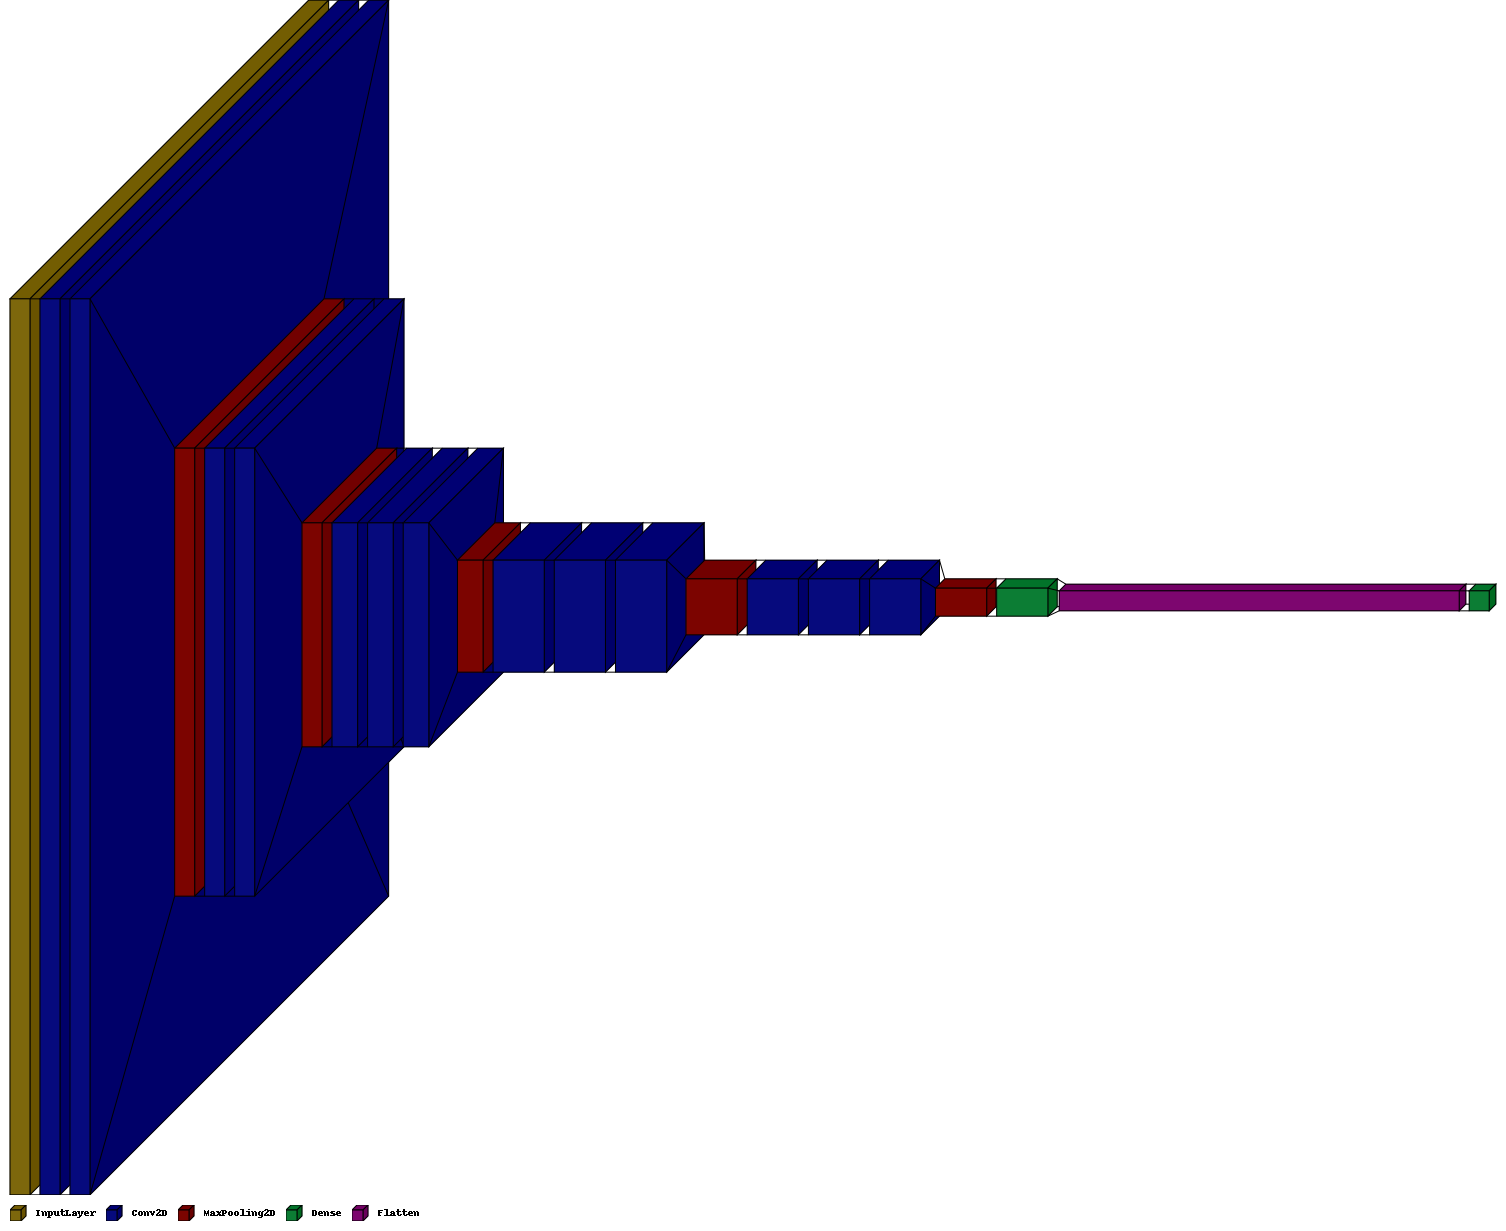

In [32]:
# set colors for each used layer
color_map = collections.defaultdict(dict)
color_map[layers.InputLayer]['fill'] = '#7D670C'
color_map[layers.Conv2D]['fill'] = '#060A7D'
color_map[layers.MaxPooling2D]['fill'] = '#7C0400'
color_map[layers.Dense]['fill'] = '#0C7D34'
color_map[layers.Flatten]['fill'] = '#7D066F'

# plot the model
visualkeras.layered_view(model, legend=True, color_map=color_map)

## 2.2 Compile model

In [33]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## 2.3 Train model

### 2.3.1 Train model

In [11]:
# load training set
train_ds = utils.image_dataset_from_directory(
    directory=train_path,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224))

# load validation set
validation_ds = utils.image_dataset_from_directory(
    directory=valid_path,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224))

# train model
history = model.fit(train_ds, epochs=10, validation_data=validation_ds, callbacks=callbacks.EarlyStopping(verbose=1, patience=2))

Found 44094 files belonging to 2 classes.
Found 19859 files belonging to 2 classes.
1378/1378 [==============================] - 5745s 4s/step - loss: 0.0614 - accuracy: 0.2733 - val_loss: 0.0738 - val_accuracy: 0.2157


### 2.3.3 Plot training results

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### 2.3.3 Evaluate model

In [13]:
# load testing set
test_ds = utils.image_dataset_from_directory(
    directory=test_path,
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(224, 224))

# evaluate the model
results = model.evaluate(test_ds, batch_size=128)

results

Found 16275 files belonging to 2 classes.
 26/509 [>.............................] - ETA: 21:51 - loss: 0.0953 - accuracy: 0.2500

KeyboardInterrupt: 

## 2.4 Persistence

### 2.4.1 Save model

In [20]:
# TODO
# model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: ../models/video/assets


INFO:tensorflow:Assets written to: ../models/video/assets


### 2.4.2 Load model

In [45]:
# TODO
# model = models.load_model(MODEL_PATH)

# 3 Results

## 3.1 Prediction for videos

In [50]:
video_prediction = dict()

for video in videos:
    video_prediction[video] = []

In [51]:
for video in videos:
    # open videoCap for video
    video_capture = cv2.VideoCapture(os.path.join(VIDEO_PATH, video))

    # read all frames of video
    while True:
        # get one frame
        success, frame = video_capture.read()

        # identify frame
        frame_number = 0

        # no more frames available
        if not success:
            break

        # reshape frame to fit to input layer
        frame = trans.resize(frame, output_shape=(224, 224))
        frame = np.reshape(frame,[1, 224, 224, 3])

        # use model to make prediction for frame
        prediction = model.predict(frame)
        print(prediction.shape[0])
        video_prediction[video].append((frame_number, prediction))

video_prediction

1/1 [==============================] - 0s 84ms/step
1
1/1 [==============================] - 0s 85ms/step
1
1/1 [==============================] - 0s 79ms/step
1
1/1 [==============================] - 0s 82ms/step
1
1/1 [==============================] - 0s 80ms/step
1
1/1 [==============================] - 0s 76ms/step
1
1/1 [==============================] - 0s 78ms/step
1
1/1 [==============================] - 0s 80ms/step
1
1/1 [==============================] - 0s 76ms/step
1
1/1 [==============================] - 0s 79ms/step
1
1/1 [==============================] - 0s 77ms/step
1
1/1 [==============================] - 0s 81ms/step
1
1/1 [==============================] - 0s 82ms/step
1
1/1 [==============================] - 0s 84ms/step
1
1/1 [==============================] - 0s 82ms/step
1
1/1 [==============================] - 0s 76ms/step
1
1/1 [==============================] - 0s 76ms/step
1
1/1 [==============================] - 0s 76ms/step
1
1/1 [=======================

KeyboardInterrupt: 